In [1]:
import pandas as pd
import numpy as np
import gmplot as gm
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
df = pd.read_csv('data/OpenGPS/points.csv').sort_values('time', ascending=True)

In [3]:
map_pos = tuple([
    df['latitude'].mean(axis=0),
    df['longitude'].mean(axis=0)
])
df_part = df[:100000]

In [4]:
gmap = gm.GoogleMapPlotter(map_pos[0], map_pos[1], 11)
gmap.heatmap(
    df_part['latitude'],
    df_part['longitude'],
    opacity=1.,
    dissipating=True
)
gmap.draw("mymap.html")

In [5]:
import smopy
from scipy import ndimage

smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png"
smopy.TILE_SIZE = 256

In [6]:
lat_low = min(df_part['latitude'])
lat_hi = max(df_part['latitude'])
long_low = min(df_part['longitude'])
long_hi = max(df_part['longitude'])

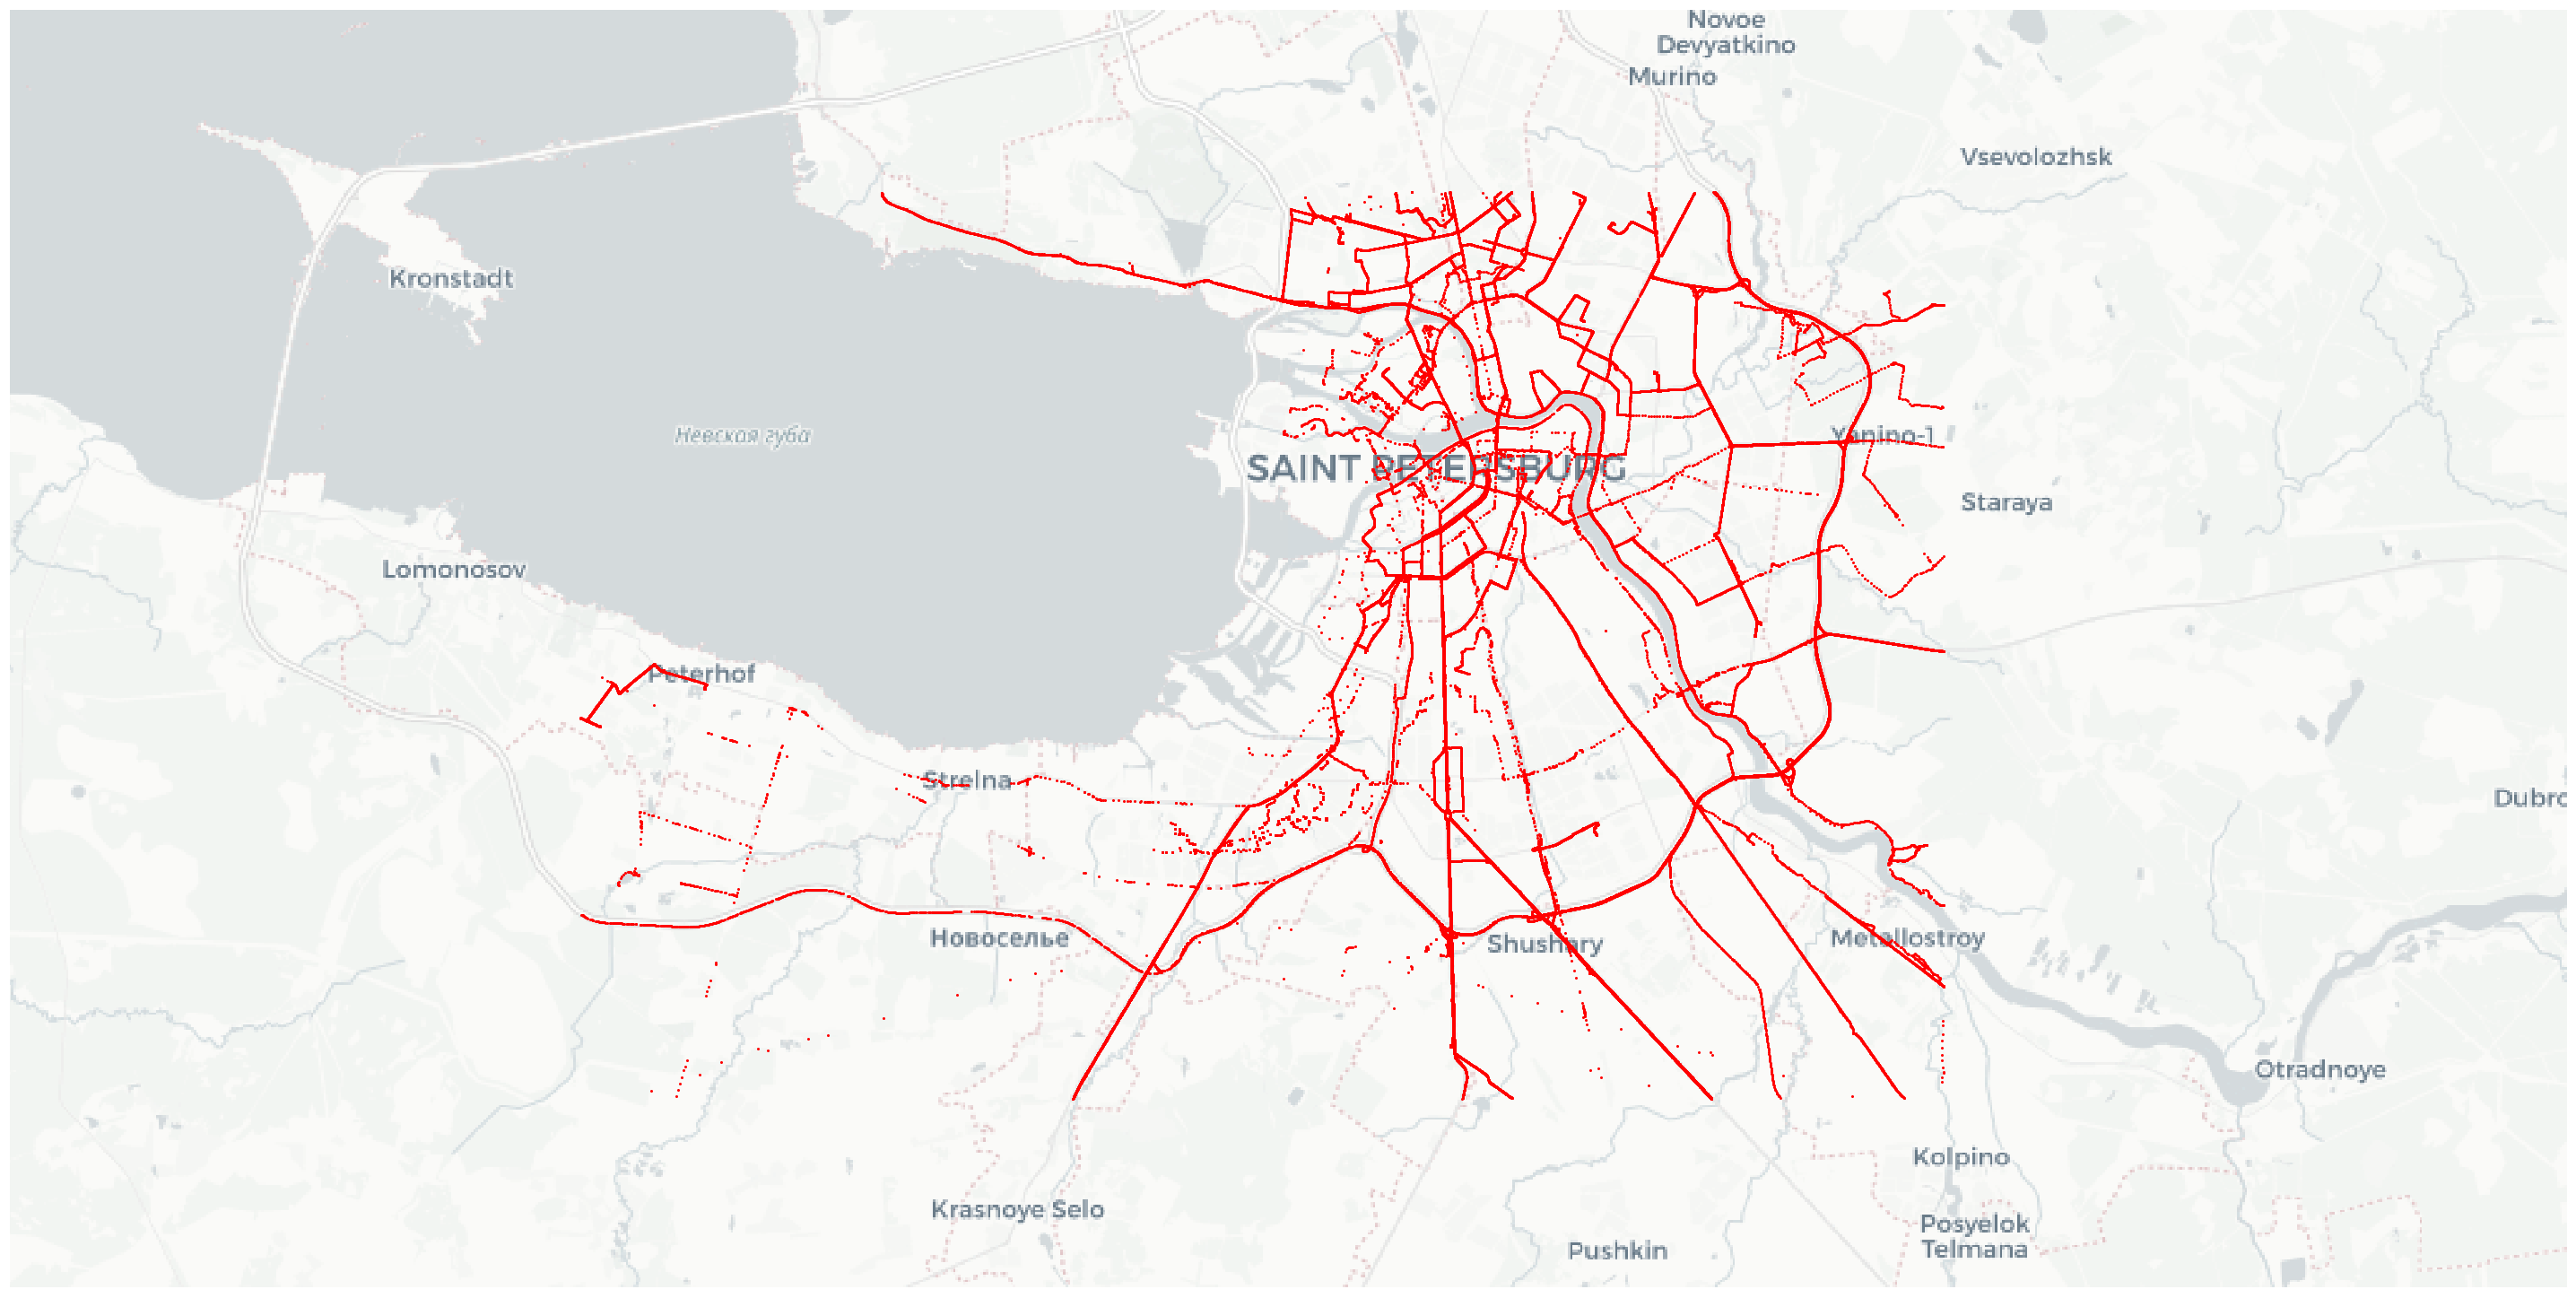

In [7]:
map_spb = smopy.Map((lat_low, long_low, lat_hi, long_hi), z=10)
x, y = map_spb.to_pixels(df_part['latitude'], df_part['longitude'])
ax = map_spb.show_mpl(figsize=(40, 40))
ax.plot(x, y, 'or', ms=2)

In [8]:
df['xPixel'] = map_spb.to_pixels(df_part['latitude'], df_part['longitude'])[0]
df['yPixel'] = map_spb.to_pixels(df_part['latitude'], df_part['longitude'])[1]

In [9]:
from matplotlib.colors import LinearSegmentedColormap

dfSpb = df[(df['latitude'].between(lat_low, lat_hi)) & (df['longitude'].between(long_low, long_hi))]
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (1,0,0,0)), (0.5, (1,0.5,0,0.8)), (0.75, (1,1,0,0.8)), (0.875, (1,1,1,1)), (1, (1,1,1,1))])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

In [10]:
bins=400
smoothing =1.

title = 'Spb'

x_raw = dfSpb['xPixel']
x = x_raw[~np.isnan(x_raw)]
y_raw = dfSpb['yPixel']
y = y_raw[~np.isnan(y_raw)]

In [11]:
heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')

ax.set_title(title, size=25)

plt.savefig(title+'.png', bbox_inches='tight')
    
ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=10)

plt.savefig(title+'.png', bbox_inches='tight')

np.amax(logheatmap)

/Users/allow/Documents/soft/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


3.8961310546177117

In [12]:
def heatMap(lon, lat, area, bins=200, smoothing=1, vmax=4, title=None):
    x = area.to_pixels(lat, lon)[0]
    y = area.to_pixels(lat, lon)[1]
    
    ax = area.show_mpl(figsize=(12, 10))
    
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    output = ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=vmax)
    
    if title:
        ax.set_title(title, size=25)
        plt.savefig(title+'.png', bbox_inches='tight')
    
    print(np.amax(logheatmap))
    return output

In [13]:
mapZoom = smopy.Map((lat_low, long_low, lat_hi, long_hi), z=10)

/Users/allow/Documents/soft/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


8.8981317047


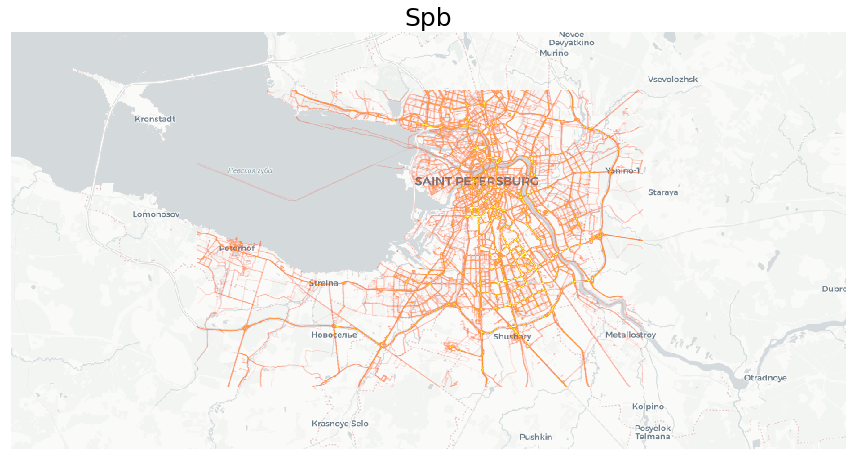

In [14]:
heatMap(dfSpb['longitude'], dfSpb['latitude'], mapZoom, bins=1000, vmax=7, title='Spb')

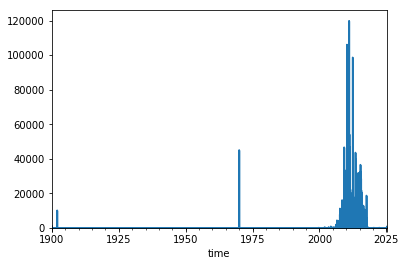

In [15]:
df_test = df
df_test.set_index(df_test.columns[2], inplace=True)
df_test.index = pd.to_datetime(df_test.index)
df_test.resample('D').count()['latitude'].plot(kind='area')